# Домашнее задание №3 (ИАД-16)
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [64]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12 (соответственно январь---декабрь)
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6 (соответственно понедельник---воскресенье)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _workthersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. Давайте посмотрим на графиках, как целевой признак зависит от остальных

C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


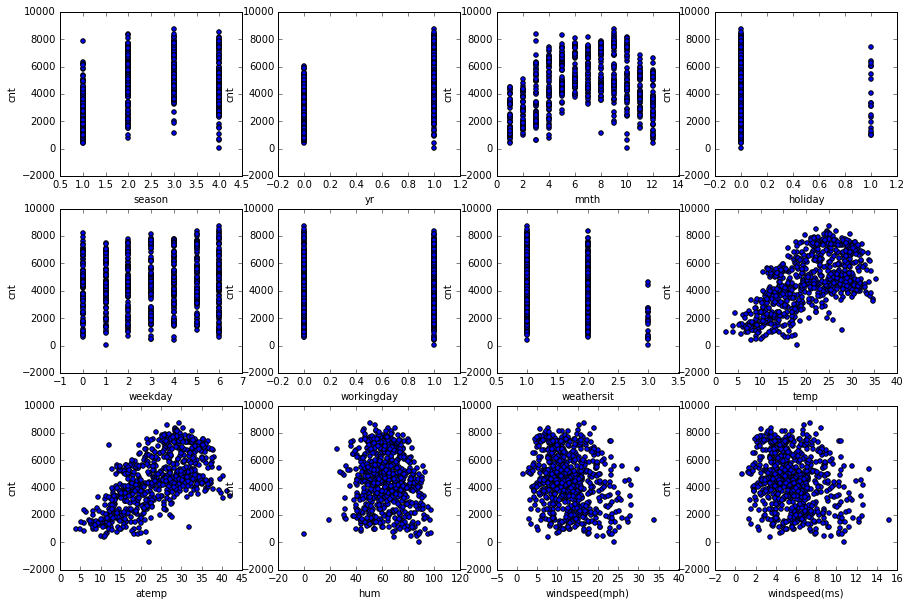

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.25 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: <b>квадратичная</b>
1. В какие дни: рабочие или выходные, людям чаще нужен велосипед?
   * ответ: <b>выходные</b>
1. Укажите одну переменную, которая не влияет на cnt.
   * ответ: <b>workingday</b>
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: <b>temp, atemp</b>

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [66]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
print("Попарная корреляция всех признаков с последним:")
df[df.columns[:-1]].corrwith(df.cnt)

Попарная корреляция всех признаков с последним:


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [67]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
print("Попарная корреляция между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt:")
df[df.columns[7:]].corr()

Попарная корреляция между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt:


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли единиц у бинарных признаков.

In [68]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
print("Средние признаков:")
print(df.mean())

Средние признаков:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Попробуем обучить самую простую линейную регрессию
А именно, построим зависимость cnt от atemp

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
# Код 1.4 (1 балл)
# Создайте объект линейного регрессора, обучите его на X = df["atemp"] и y = df["cnt]
# Затем сделайте предсказание на X_test = linspace (переменная, объявленная ниже) и запишите в переменную y_test
regressor = LinearRegression()
linspace = np.linspace(0, 40, 1000)[:, np.newaxis]

# Тренировочные данные
X_train = df.atemp.values
y_train = df.cnt.values

# Train
regressor.fit(X_train.reshape(len(X_train),1), y_train.reshape(len(y_train),1))

# Test
y_test = regressor.predict(linspace)

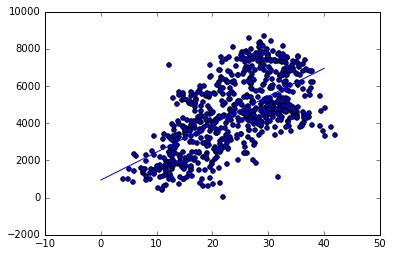

In [71]:
plt.scatter(df["atemp"], df["cnt"])
plt.plot(linspace.ravel(), y_test)

У вас должна получиться прямая, проходящая через изображенные точки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на дисперсию. Это можно сделать с помощью метода scale:

In [72]:
from sklearn.preprocessing import scale

In [73]:
X = scale(df[df.columns[:-1]])
y = df["cnt"]

Давайте обучим линейную регрессию на полных данных и посмотрим на веса признаков.

In [74]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

regr = LinearRegression()
regr.fit(X,y)

print("Веса признаков:")
for element in zip(df.columns,regr.coef_):
    print(element)

Веса признаков:
('season', 570.86899601924495)
('yr', 1021.970839516987)
('mnth', -141.30561736333402)
('holiday', -86.757940671711594)
('weekday', 137.22300183651623)
('workingday', 56.393862951102221)
('weathersit', -330.22891812271155)
('temp', 367.45817536624122)
('atemp', 585.57127245110087)
('hum', -145.61033040495613)
('windspeed(mph)', 12459488819054.459)
('windspeed(ms)', -12459488819252.914)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу $||Xw-y||$ прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором — Ridge.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [75]:
from sklearn.linear_model import Ridge, Lasso

In [76]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией

lasso = Lasso()
lasso.fit(X,y)

print("Веса признаков:")
for element in zip(df.columns,lasso.coef_):
    print(element)

Веса признаков:
('season', 560.24161603088646)
('yr', 1019.4634940657194)
('mnth', -128.73062703678733)
('holiday', -86.152781333711133)
('weekday', 137.34789390496334)
('workingday', 55.212370641356699)
('weathersit', -332.36985696234854)
('temp', 376.36323620969438)
('atemp', 576.53079350455528)
('hum', -144.12915500348606)
('windspeed(mph)', -197.13968940249507)
('windspeed(ms)', -2.8040615753648517e-08)


In [77]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией

ridge = Ridge()
ridge.fit(X,y)

print("Веса признаков:")
for element in zip(df.columns,ridge.coef_):
    print(element)

Веса признаков:
('season', 563.06457225201154)
('yr', 1018.9483787875286)
('mnth', -131.87332028246988)
('holiday', -86.746097997092576)
('weekday', 138.00511117871892)
('workingday', 55.903110375064998)
('weathersit', -332.3497884990748)
('temp', 386.45788919193421)
('atemp', 566.34704706004061)
('hum', -145.07132729867175)
('windspeed(mph)', -99.259441082090646)
('windspeed(ms)', -99.259441154042463)


__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл)__: <i>введение регуляризации снижает разброс весов признаков, снижает зависимость между ними (это решает проблему мультиколлениарности), а также может отсеить часть из них, устанавливая весовые значения нулевыми (для Lasso). Всё это позволяет снизить вероятность переобучения модели.</i> 

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение последнему факту было дано на лекции (всё из-за ромбообразных линий уровня L1-нормы).

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$. 

In [78]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso,
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i in range(0, len(alphas)):
    coefs_lasso[i] = Lasso(alpha=alphas[i]).fit(X,y).coef_
    coefs_ridge[i] = Ridge(alpha=alphas[i]).fit(X,y).coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

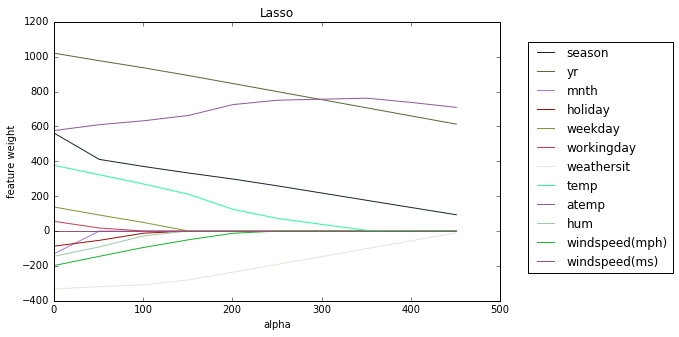

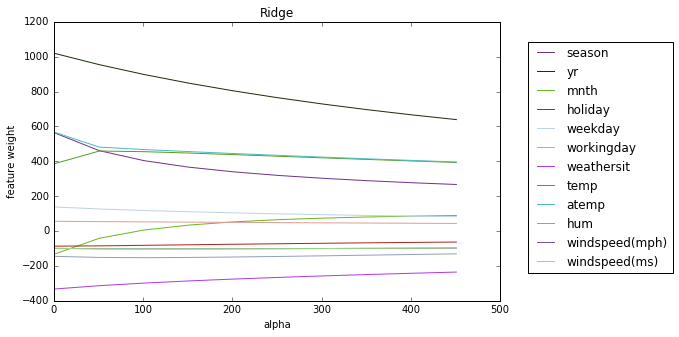

In [79]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

__Блок 3. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регрессор (Ridge или Lasso) агрессивнее уменьшает веса?
    * Ответ: <b>Lasso</b>
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: <b>веса обнулятся</b>
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha? А Ridge?
    * Ответ: <b>да, можно утверждать, что Lasso исключает один из признаков при любом значении alpha. Ridge не исключает</b>   
1. Какой из регрессоров подойдет для отбора неинформативных признаков?
    * Ответ: <b>Lasso</b>

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого в scikit-learn есть специальный класс __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) × k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [19]:
from sklearn.linear_model import LassoCV

График усредненного по строкам MSE в зависимости от alpha:


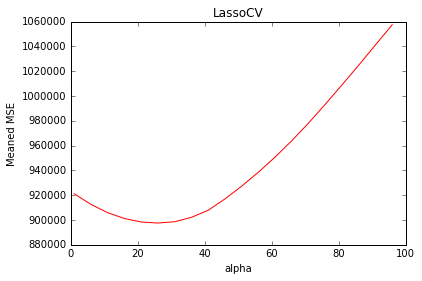

Выбранное alpha:  26
Пары признак-коэффициент: 
('season', 431.50501463394619)
('yr', 997.59495798591013)
('mnth', -0.0)
('holiday', -71.475853467463821)
('weekday', 113.41239026287388)
('workingday', 36.831355314954315)
('weathersit', -323.67910842163877)
('temp', 348.31239784094066)
('atemp', 599.39149098211328)
('hum', -122.41739716302776)
('windspeed(mph)', -170.44942053622842)
('windspeed(ms)', -2.2573583847276162e-08)


In [60]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов

alphas = np.arange(1, 100, 5)
lasso_cv = LassoCV(alphas = alphas)
lasso_cv.fit(X,y)

matrix = lasso_cv.mse_path_

# Средние по строкам
means = np.mean(matrix, axis = 1)

print("График усредненного по строкам MSE в зависимости от alpha:")
plt.plot(lasso_cv.alphas_, means,"r")
plt.xlabel("alpha")
plt.ylabel("Meaned MSE")
plt.title("LassoCV")
plt.show()

print("Выбранное alpha: ",lasso_cv.alpha_)
print("Пары признак-коэффициент: ")
for element in zip(df.columns,lasso_cv.coef_):
    print(element)

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Значения alpha, соответствующие минимумам MSE на каждом разбиении:  [56, 41, 1]


Графики, соответствующие разбиениям:


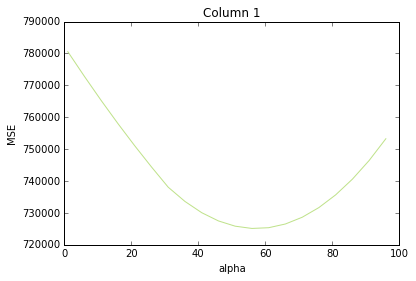

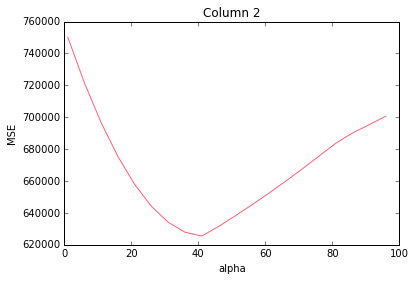

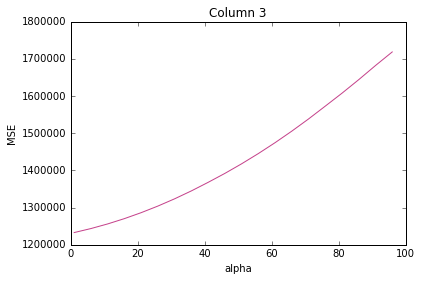

In [47]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

# Минимумы по каждому столбцу
mins = np.min(matrix, axis=0)

# Индексы этих элементов в mse_path_
indexes = np.where(matrix == mins)

# Альфы, соотвествующие минимумам
min_alphas = [lasso_cv.alphas_[indexes[0][i]] for i in range(0, mins.shape[0])]
print("Значения alpha, соответствующие минимумам MSE на каждом разбиении: ", min_alphas)
print("\n")

print("Графики, соответствующие разбиениям:") 
for x in range(0,3):
    plt.plot(lasso_cv.alphas_, matrix[:,x], color = np.random.rand(3))
    title = "Column " + str(x+1)
    plt.title(title)
    plt.xlabel("alpha")
    plt.ylabel("MSE")
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 4. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами, посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: <b>возрастающая линейная зависимость cnt видна от признаков temp и atemp, для признаков season и year она не видна. Логично утверждать, что количество арендованных велосипедов будет расти с ростом температуры (до её определённого значения). Однако это вряд ли можно утверждать для признаков season и year</b>
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами, посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: <b>зависимость видна от признаков weathersit, hum и windspeed(mph), но не видно, что она является линейной. Да, логично утвержать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды</b>

1. Выберите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: <b>Признаки: mnth, windspeed(ms). Да, верно, что они не влияют на спрос на велосипеды</b>

Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.